# Construir una Red Neuronal Convolucionada para reconocimiento de imágenes

Los resultados de este cuaderno van a variar un poco por el grado de aleatoriedad en la partición de los datos, así como en la inicialización de la red neuronal.

# Explorar y preprocesar datos

Primero tenemos que importar los datos, esta es su estructura:

- Imágenes: 32 * 32 pixeles
- Etiquetas: 10 posibles (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck)
- Tamaño: 60000 imágenes, particionadas entre 50000 para entrenamiento y 10000 para prueba

![ejemplo](ejemplo.png)
https://www.cs.toronto.edu/~kriz/cifar.html

Obtenemos los datos primero que todo

In [78]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

Veamos la forma de los datos

In [42]:
print('x_train shape:', x_train.shape)

x_train shape: (50000, 32, 32, 3)


Es decir, 5000 imágenes, 32 pixeles de alto por 32 de ancho, y 3 pixeles de profundidad (correspondientes a los colores rojo, verde y azul)

In [43]:
print('y_train shape:', y_train.shape)

y_train shape: (50000, 1)


Hay un número (etiqueta) por cada una de las 50000 imágenes

Una imagen individual:

In [44]:
print(x_train[0])

[[[ 59  62  63]
  [ 43  46  45]
  [ 50  48  43]
  ...
  [158 132 108]
  [152 125 102]
  [148 124 103]]

 [[ 16  20  20]
  [  0   0   0]
  [ 18   8   0]
  ...
  [123  88  55]
  [119  83  50]
  [122  87  57]]

 [[ 25  24  21]
  [ 16   7   0]
  [ 49  27   8]
  ...
  [118  84  50]
  [120  84  50]
  [109  73  42]]

 ...

 [[208 170  96]
  [201 153  34]
  [198 161  26]
  ...
  [160 133  70]
  [ 56  31   7]
  [ 53  34  20]]

 [[180 139  96]
  [173 123  42]
  [186 144  30]
  ...
  [184 148  94]
  [ 97  62  34]
  [ 83  53  34]]

 [[177 144 116]
  [168 129  94]
  [179 142  87]
  ...
  [216 184 140]
  [151 118  84]
  [123  92  72]]]


Para poder visualizarlo como imagen de verdad utilizaremos matplotlib:

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline

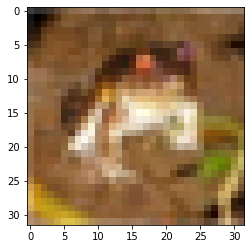

In [46]:
img = plt.imshow(x_train[0])

Se ve bastante pixalado por su pequeño tamaño

Ahora exploremos la etiqueta de esta imagen

In [47]:
print('La etiqueta es:', y_train[0])

La etiqueta es: [6]


Las etiquetas se traducen de la siguiente manera:
![tablae](tablae.png)

Miremos una imagen más

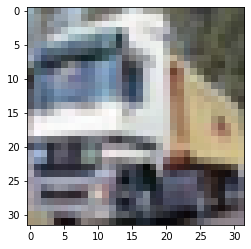

In [48]:
img = plt.imshow(x_train[1])

In [49]:
print('La etiqueta es:', y_train[1])

La etiqueta es: [9]


Como las etiquetas no están ordenadas de ninguna manera en específico, la red podría tener problemas al definir criterios de decisión. En ese caso recurrimos al 'one-hot encoding' de nuevo utilizando Keras:

![onehot](onehot.png)

In [50]:
import keras
y_train_one_hot = keras.utils.to_categorical(y_train, 10)
y_test_one_hot = keras.utils.to_categorical(y_test, 10)

Miremos cómo esa segunda imagen de antes quedó convertida con el nuevo formato

In [51]:
print('Etiqueta one hot:', y_train_one_hot[1])

Etiqueta one hot: [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


Ahora convertimos los datos en un formato que pueda almacenar decimales, y adicionalmente, dividimos entre el total de valores que puede almacenar un pixel para dejar todo entre 0 y 1.

In [52]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = x_train / 255
x_test = x_test / 255

In [53]:
x_train[0]

array([[[0.23137255, 0.24313726, 0.24705882],
        [0.16862746, 0.18039216, 0.1764706 ],
        [0.19607843, 0.1882353 , 0.16862746],
        ...,
        [0.61960787, 0.5176471 , 0.42352942],
        [0.59607846, 0.49019608, 0.4       ],
        [0.5803922 , 0.4862745 , 0.40392157]],

       [[0.0627451 , 0.07843138, 0.07843138],
        [0.        , 0.        , 0.        ],
        [0.07058824, 0.03137255, 0.        ],
        ...,
        [0.48235294, 0.34509805, 0.21568628],
        [0.46666667, 0.3254902 , 0.19607843],
        [0.47843137, 0.34117648, 0.22352941]],

       [[0.09803922, 0.09411765, 0.08235294],
        [0.0627451 , 0.02745098, 0.        ],
        [0.19215687, 0.10588235, 0.03137255],
        ...,
        [0.4627451 , 0.32941177, 0.19607843],
        [0.47058824, 0.32941177, 0.19607843],
        [0.42745098, 0.28627452, 0.16470589]],

       ...,

       [[0.8156863 , 0.6666667 , 0.3764706 ],
        [0.7882353 , 0.6       , 0.13333334],
        [0.7764706 , 0

Hasta ahora solo hemos descargado los datos, visualizado imágenes, codificar las etiquetas y escalar las imágenes.

# Construir y entrenar la red convolucionada

La arquitectura que vamos a construir es la siguiente:

- Conv Layer (Filter size 3x3, Depth 32)
- Conv Layer (Filter size 3x3, Depth 32)
- Max Pool Layer (Filter size 2x2)
- Dropout Layer (Prob of dropout 0.25)
- Conv Layer (Filter size 3x3, Depth 64)
- Conv Layer (Filter size 3x3, Depth 64)
- Max Pool Layer (Filter size 2x2)
- Dropout Layer (Prob of dropout 0.25)
- FC Layer (512 neurons)
- Dropout Layer (Prob of dropout 0.5)
- FC Layer, Softmax (10 neurons)

In [54]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

El modelo vacío:

In [55]:
model = Sequential()

Para todas las capas excepto para la de salida, se aplicará la función de activación ReLU, a continuación configuramos la primera capa

In [56]:
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32,32,3)))

Segunda capa

In [57]:
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))

Capa pooling para reducir el tamaño espacial de la representación y hacer el modelo más eficiente

In [58]:
model.add(MaxPooling2D(pool_size=(2, 2)))

Capa de dropout

In [59]:
model.add(Dropout(0.25))

Para las siguientes 4 capas ampliamos la profundidad

In [60]:
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

Ahora sigue la capa de neuronas conectadas, que tenemos que aplanar puesto que se encuentran representadas de forma 'cúbica'

In [61]:
model.add(Flatten())

La capa FC con 512 neuronas

In [62]:
model.add(Dense(512, activation='relu'))

Otra de capa de dropout

In [63]:
model.add(Dropout(0.5))

Una última capa densa con 10 neuronas resultado del softmax

In [64]:
model.add(Dense(10, activation='softmax'))

Podemos ver el resumen de toda la arquitectura

In [65]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 64)         

Compilamos el modelo:

Como función de pérdida utilizamos entropía cruzada categórica, el optimizador es Adam (un tipo de gradiente estocástico) que entrena un poco mejor. Y por último la precisión del modelo.

In [66]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Ahora, corremos el entrenamiento:

Tamaño del lote 32 y 20 épocas.

Especificamos adentro del modelo la partición de entrenamiento

In [67]:
hist = model.fit(x_train, y_train_one_hot, 
           batch_size=32, epochs=20, 
           validation_split=0.2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/20
40000/40000 [==============================] - 220s 5ms/step - loss: 1.5778 - accuracy: 0.4191 - val_loss: 1.1972 - val_accuracy: 0.5701
Epoch 2/20
40000/40000 [==============================] - 215s 5ms/step - loss: 1.1484 - accuracy: 0.5911 - val_loss: 0.9870 - val_accuracy: 0.6459
Epoch 3/20
40000/40000 [==============================] - 212s 5ms/step - loss: 0.9741 - accuracy: 0.6597 - val_loss: 0.9391 - val_accuracy: 0.6766
Epoch 4/20
40000/40000 [==============================] - 209s 5ms/step - loss: 0.8674 - accuracy: 0.6919 - val_loss: 0.7646 - val_accuracy: 0.7337
Epoch 5/20
40000/40000 [==============================] - 244s 6ms/step - loss: 0.7933 - accuracy: 0.7204 - val_loss: 0.7665 - val_accuracy: 0.7339
Epoch 6/20
40000/40000 [==============================] - 253s 6ms/step - loss: 0.7299 - accuracy: 0.7417 - val_loss: 0.7118 - val_accuracy: 0.7529
Epoch 7/20
40000/40000 [==============================] - 245s

Cuando termine de entrenar, podemos visualizar los resultados de entrenamiento, pérdida y precisión:

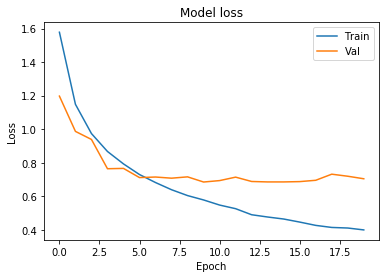

In [68]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

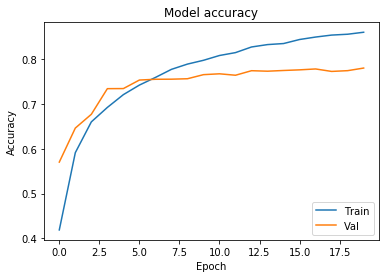

In [69]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

Se puede probar modificar los hiperparámetros o agregar más épocas para mejorar la precisión. Una vez se haya escogido un modelo, podemos evaluarlo contra la partición de prueba:

In [70]:
model.evaluate(x_test, y_test_one_hot)[1]

10000/10000 [==============================] - 17s 2ms/step


0.7757999897003174

Luego del largo rato de entrenamiento, guardamos los resultados del modelo para volver a utilizarlo luego.

In [79]:
model.save('my_cifar10_model.h5')

# Probar el modelo con imágenes propias

Almacenamos la imagen en el mismo directorio del cuaderno de jupyter y la cargamos:

In [72]:
my_image = plt.imread("cat.jpg")

Lo primero es escalar la imagen al tamaño que necesita el modelo (32 * 32 *3)

In [73]:
from skimage.transform import resize
my_image_resized = resize(my_image, (32,32,3))

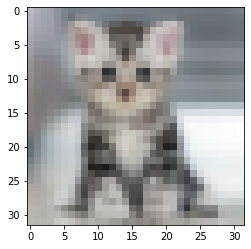

In [74]:
img = plt.imshow(my_image_resized)

Es momento de predecir la etiqueta de la imagen:

In [75]:
import numpy as np
probabilities = model.predict(np.array( [my_image_resized,] ))

In [76]:
probabilities

array([[8.0801845e-03, 8.4383528e-06, 1.0652363e-02, 3.8580704e-01,
        1.9863652e-02, 5.1040560e-01, 2.0998346e-02, 4.2518515e-02,
        1.4794788e-03, 1.8637536e-04]], dtype=float32)

In [77]:
number_to_class = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
index = np.argsort(probabilities[0,:])
print("Clase más probable:", number_to_class[index[9]], "-- Probability:", probabilities[0,index[9]])
print("Segunda clase más probable:", number_to_class[index[8]], "-- Probability:", probabilities[0,index[8]])
print("Tercera clase más probable:", number_to_class[index[7]], "-- Probability:", probabilities[0,index[7]])
print("Cuarta clase más probable:", number_to_class[index[6]], "-- Probability:", probabilities[0,index[6]])
print("Quinta clase más probable:", number_to_class[index[5]], "-- Probability:", probabilities[0,index[5]])

Clase más probable: dog -- Probability: 0.5104056
Segunda clase más probable: cat -- Probability: 0.38580704
Tercera clase más probable: horse -- Probability: 0.042518515
Cuarta clase más probable: frog -- Probability: 0.020998346
Quinta clase más probable: deer -- Probability: 0.019863652
